**Эпиграф**

Для решения этой работы были проштудирована книга Kim Falk Practical Recommender Systems (Manning, 2019), а также множество статей в интернете. Была попытка реализовать несколько известных алгоритмов рекомендательных систем, такие как Collaborative Filtering, Item-to-Item similarity, Content-Based Filtering. В конце концов, реальность оказалась проще.

### Главная первая ячейка

Загружаем необходимые библиотеки, определяем функции сохранения данных на диск, определяем Godlike-class RecData, который будет сохранять полученную статистику.

In [34]:
import numpy as np
import pandas as pd
from scipy import sparse
import pickle
from scipy import spatial

import tensorflow as tf
import keras
from IPython.display import clear_output

def save_obj(obj, filename):
    with open("./drive/My Drive/data/recsys_diploma/" + filename, "wb") as f:
        pickle.dump(obj, f)

def load_obj(filename):
    with open("./drive/My Drive/data/recsys_diploma/" + filename, "rb") as f:
        return pickle.load(f)

class RecData():
    def __init__(self, UIDS, IIDS):
        self.AISLE_ITEMS = {}
        self.AISLE_ITEMS_PROBA = {}
        self.DEPARTMENT_ITEMS = {}
        self.DEPARTMENT_ITEMS_PROBA = {}
        self.user_data = {}
        self.item_data = {}        
        self.UIDS = UIDS
        self.IIDS = IIDS
        self.UIDS_index = {uid: i for i, uid in enumerate(UIDS)}
        self.UIDS_inverse_index = {i: uid for i, uid in enumerate(UIDS)}
        self.IIDS_index = {iid: i for i, iid in enumerate(IIDS)}
        self.IIDS_inverse_index = {i: iid for i, iid in enumerate(IIDS)}

N = 100000 # число пользователей
M = 49688  # число продуктов

### 1. Первичная загрузка и обработка данных

In [ ]:
#Рабочий вариант (собственный GoogleDrive)
TX_PATH = "./drive/My Drive/data/recsys_diploma/transactions.csv"
PRODUCTS_PATH = "./drive/My Drive/data/recsys_diploma/products.csv"

In [ ]:
!pip install gdown

In [ ]:
#Вариант для проверяющих
import gdown

TX_URL = "https://drive.google.com/uc?export=download&id=1b5n6uf-f9pP9dp4YI5XBIiZFzrrFS10F"
PRODUCTS_URL = "https://drive.google.com/uc?export=download&id=1VYcJqx7pQeoD8p6nJkSAtbTAxwfKPyjQ"

gdown.download(TX_URL, "transactions.csv")
gdown.download(PRODUCTS_URL, "products.csv")

TX_PATH = "./transactions.csv"
PRODUCTS_PATH = "./products.csv"

In [ ]:
#Загружаем продукты
pr = pd.read_csv(PRODUCTS_PATH)
pr.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


In [ ]:
#Строим словарь item_data
item_data = {}

for i, row in pr.iterrows():
    item_data[row.product_id] = {
        "aisle": row.aisle_id,
        "department": row.department_id
    }
len(item_data)

49688

In [ ]:
#Загружаем транзакции
tx = pd.read_csv(TX_PATH)
UIDS = sorted(tx['user_id'].unique())
IIDS = sorted(pr['product_id'].unique())

len(UIDS), len(IIDS)

(100000, 49688)

In [ ]:
tx.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,1,2,8,NaN,196,1.0,0.0
1,2539329,1,1,2,8,NaN,14084,2.0,0.0
2,2539329,1,1,2,8,NaN,12427,3.0,0.0
3,2539329,1,1,2,8,NaN,26088,4.0,0.0
4,2539329,1,1,2,8,NaN,26405,5.0,0.0


In [ ]:
#Создаем глобальный объект данных
data = RecData(UIDS, IIDS)
data.item_data = item_data

In [ ]:
#Построение словарей для извлечения информации по айтемам
data.DEPARTMENT_ITEMS = {dpt_id : pr[pr["department_id"] == dpt_id]["product_id"].values for dpt_id in pr["department_id"].unique()}
data.AISLE_ITEMS = {aisle_id : pr[pr["aisle_id"] == aisle_id]["product_id"].values for aisle_id in pr["aisle_id"].unique()}

len(data.DEPARTMENT_ITEMS), len(data.AISLE_ITEMS)

(21, 134)

In [ ]:
#Считаем глобальную вероятность появления продукта в заказе P(I), а заодно глобальное число появлений каждого продукта
orders_num = len(tx['order_id'].unique())
tx_num = len(tx)

for iid in data.IIDS:
    data.item_data[iid]['global_p'] = 0.0   # P(I) для заказа
    data.item_data[iid]['dpt_p'] = 0.0      # P(I | D)
    data.item_data[iid]['asl_p'] = 0.0      # P(I | A)
    data.item_data[iid]['global_count'] = 0 

for i, row in tx.groupby("product_id").agg({"order_id":"count"}).reset_index().iterrows():
    data.item_data[row.product_id]['global_p'] = row.order_id / orders_num
    data.item_data[row.product_id]['global_count'] = row.order_id

In [ ]:
#Считаем условную вероятность вхождения продукта I при департаменте D P(I | D)
for dpt_id, iids in data.DEPARTMENT_ITEMS.items():
    #Общее число появлений всех продуктов всех департаментов
    den = np.sum(data.item_data[iid]['global_count'] for iid in iids)
    for iid in iids:
        data.item_data[iid]['dpt_p'] = data.item_data[iid]['global_count'] / den

#То же для продукта I и категории A P(I | A)
for asl_id, iids in data.AISLE_ITEMS.items():
    #Общее число появлений всех продуктов всех категорий
    den = np.sum([data.item_data[iid]['global_count'] for iid in iids])
    for iid in iids:
        data.item_data[iid]['asl_p'] = data.item_data[iid]['global_count'] / den

data.item_data[1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


{'aisle': 61,
 'asl_p': 0.008161910382329385,
 'department': 19,
 'dpt_p': 0.0006532215757947881,
 'global_count': 1549,
 'global_p': 0.0005949290079549191}

In [ ]:
#Построение для извлечения информации по юзерам
user_dict = tx.sort_values(["order_number", "add_to_cart_order"]).groupby(["user_id", "order_number"]).agg({"product_id": lambda x: list(x)}).groupby(level=0).apply(lambda df: df.xs(df.name).to_dict()).to_dict()

print('OK')

OK


In [ ]:
from collections import Counter

#Маппинг продукт -> категория для заказа
def to_aisles(o):
    return [data.item_data[iid]['aisle'] for iid in o]

#Маппинг продукт -> департамент для заказа
def to_departments(o):
    return [data.item_data[iid]['department'] for iid in o]

#Нормализация частот, посчитанных в Counter
def norm_counter(counter, n):
    d = dict(counter.most_common())
    for k, _ in d.items():
        d[k] /= n
    return d

#Нормализация частот, посчитанных в словаре
def norm_proba(d, n):
    for k, _ in d.items():
        d[k] /= n
    return d

#Расчет вероятности департамента/категории в заказе
def update_proba(d, o):
    counter = Counter()
    counter.update(o)
    d1 = norm_counter(counter, len(o))
    for k, _ in d1.items():
        if k in d:
            d[k] += d1[k]
        else:
            d[k] = d1[k]
    return d

for uid, v in user_dict.items():
    data.user_data[uid] = {
        'orders': [], #заказы в виде списков
        'item_p': {}, #априорная вероятность появления продуктов у пользователя по всей истории
        'dpt_p': {}, #усредненная вероятность появления категории у пользователя в заказе
        'asl_p': {} #усредненная вероятность появления департамента у пользователя в заказе
                           }
    counter_items = Counter()
    counter_aisles = {}
    counter_dpts = {}
    _sum = 0
    n = 0
    for _, order in v['product_id'].items():
        data.user_data[uid]['orders'].append(order)
        counter_items.update(order)
        counter_aisles = update_proba(counter_aisles, to_aisles(order))
        counter_dpts = update_proba(counter_dpts, to_departments(order))
        _sum += len(order)
        n += 1

    data.user_data[uid]['item_p'] = norm_counter(counter_items, _sum) 
    data.user_data[uid]['asl_p'] = norm_proba(counter_aisles, n) 
    data.user_data[uid]['dpt_p'] = norm_proba(counter_dpts, n) 

In [ ]:
data.user_data[1]

{'asl_p': {21: 0.14194444444444448,
  23: 0.21527777777777776,
  24: 0.06666666666666667,
  45: 0.01111111111111111,
  53: 0.03333333333333333,
  54: 0.04,
  77: 0.22305555555555556,
  88: 0.02,
  91: 0.03111111111111111,
  117: 0.15861111111111112,
  120: 0.01111111111111111,
  121: 0.04777777777777778},
 'dpt_p': {4: 0.06666666666666667,
  7: 0.22305555555555556,
  13: 0.02,
  14: 0.04777777777777778,
  16: 0.21749999999999997,
  17: 0.04,
  19: 0.38500000000000006},
 'item_p': {196: 0.1694915254237288,
  10258: 0.15254237288135594,
  10326: 0.01694915254237288,
  12427: 0.1694915254237288,
  13032: 0.05084745762711865,
  13176: 0.03389830508474576,
  14084: 0.01694915254237288,
  17122: 0.01694915254237288,
  25133: 0.13559322033898305,
  26088: 0.03389830508474576,
  26405: 0.03389830508474576,
  30450: 0.01694915254237288,
  35951: 0.01694915254237288,
  38928: 0.01694915254237288,
  39657: 0.01694915254237288,
  41787: 0.01694915254237288,
  46149: 0.05084745762711865,
  49235: 0

In [ ]:
#Saving basic data
save_obj(data, "data.bin")

### 2. Collaborative filtering. Построение IxU и IxI матрицы

Неудачный вариант, использование Collaborative Filtering не очень подходит для этой задачи. Матрица IxI считалась более суток.

In [35]:
#Loading basic data
data = load_obj("data.bin")

Идея состоит в следующем: рассчитаем матрицу IxU, где в пересечении будет стоять синтетический "рейтинг", равный вероятности появления соответствующего продукта у пользователя. Затем рассчитаем матрицу item-to-item similarity с помощью косинусного расстояния и найдем похожие друг на друга продукты.

In [ ]:
#Cчитаем матрицу IxU строки - продукты, столбцы - пользователи
I_U = np.zeros((M, N), dtype=np.float16) # (M, N)

for j, uid in enumerate(data.UIDS):
    udata = data.user_data[uid]
    for iid, p in udata['item_proba'].items(): #расставляем по столбцам
        i = data.IIDS_index[iid]
        I_U[i, j] = p

I_U_norms = [(tf.norm(I_U[j, :], ord=2) + 1e-06).numpy() for j in range(0, M)]  # (1, M)

#L2-нормализация строк матрицы IxU, чтобы не приходилось это делать каждый раз при вычислении косинусного расстояния
for j in range(M):
    I_U[j, :] = I_U[j, :]/I_U_norms[j]
#I_U = I_U * (1/np.array(I_U_norms).reshape(1, -1).T) жрет слишком много памяти

tfI_U = tf.convert_to_tensor(I_U, dtype=tf.float16)

In [ ]:
#Сохраняем в sparse-формате
spI_U = sparse.csr_matrix(I_U)
save_obj(spI_U, "I_U.bin")
save_obj(I_U_norms, "I_U_norms.bin")

In [ ]:
#2 вaариант - загружаем с диска разреженную матрицу IxU - уже не работает, изза памяти
I_U = load_obj("I_U.bin")
I_U_norms = load_obj("I_U_norms.bin")
I_U_norms = 1./np.expand_dims(np.array(I_U_norms), 0).T
I_U = I_U.astype(np.float16)
print("I_U loaded")
I_U = np.multiply(I_U, I_U_norms)
print("I_U normalized")
coo = spI_U.tocoo()
indices = np.mat([coo.row, coo.col]).transpose()
tfI_U = tf.SparseTensor(indices, coo.data, coo.shape)
tfI_U = tf.sparse.to_dense(tfI_U, validate_indices=False)
print("I_U restored")

In [ ]:
%%timeit -n 100
tf.repeat(tf.expand_dims(a, 0), 3, axis=0)

100 loops, best of 3: 1.29 ms per loop


In [ ]:
%%timeit -n 10
tf.repeat(tfI_U[1:2, :], 3, axis=0)

10 loops, best of 3: 1.23 ms per loop


In [ ]:
%%timeit -n 10
[tfI_U[1:2, :] for i in range(3)]

10 loops, best of 3: 211 µs per loop


In [ ]:
#Функция для вычисления косинусной меры - максимально оптимизирована
def tf_cosine_similarity_batch(i, j, batch_size):
    count = min(M-j, batch_size)
    v1 = tf.repeat(tfI_U[i:i+1, :], count, axis=0)
    v2 = tfI_U[j:j+count, :]
    return tf.math.reduce_sum(v1 * v2, axis=1).numpy()

In [ ]:
%%timeit -n 10
tf_cosine_similarity_batch(0, 1, 4096)

10 loops, best of 3: 6.01 ms per loop


In [ ]:
#1 итерация
I_I = np.zeros((M,))
I_I[0] = 1.0
for j in range(1, M, BATCH_SIZE):
    I_I[j:j + BATCH_SIZE] = batch = tf_cosine_similarity_batch(0, j, BATCH_SIZE)
I_I = sparse.csr_matrix(I_I)
print("1st iteration complete")
save_obj(I_I, "I_I.bin")
print("matrix saved")
I_I.shape

In [ ]:
import scipy
import datetime

BATCH_SIZE = 4096

I_I = load_obj("I_I.bin")
print("Initial shape:", I_I.shape)
start_time = datetime.datetime.now()
print("Initial time: ", start_time.strftime('%Y-%m-%d %H:%M:%S'))

for i in range(I_I.shape[0], M):
    block = np.zeros((M, ))
    block[i] = 1.0
    block[:i] = I_I[:i, i].toarray().T
    for j in range(i+1, M, BATCH_SIZE):
        block[j:j+BATCH_SIZE] = tf_cosine_similarity_batch(i, j, BATCH_SIZE)
    I_I = scipy.sparse.vstack((I_I, sparse.csr_matrix(block)))
    if i%100 == 0:
        delta = (datetime.datetime.now() - start_time).total_seconds()
        print(f"+{delta:4.1f} s. Completed {i}-th line of similarity matrix", I_I.shape)
        save_obj(I_I, "I_I.bin")

save_obj(I_I, "I_I.bin")

Initial shape: (49601, 49688)
Initial time:  2020-12-09 14:09:43


В итоге матрица IxI считалась более суток, что явно не соответствует критерию, указанному в задании, более того расчет замедлялся к последним строкам, а не ускорялся, что связано с медленным копированием уже посчитанных значений из sparse-матрицы. Держать обе матрицы в памяти не представляется возможным даже на Colab Premium, т.к. объем даже на np.float16 превышает 25 Гб RAM.

### 3. Алгоритм ранжирования и Sample submission

Постановка задачи заключается в построении генеративной модели по очень ограниченному набору наблюдений из неизвестного распределения. Строго говоря, подобная система не является рекомендательной, ее функция -- предсказать, что купит пользователь, а не что ему порекомендовать _помимо_ того, что он купил.  Здравый смысл подсказывает, что наибольший вес нужно придать тем продуктам, которые явно содержатся в истории его покупок, это распределение мы знаем a priori. Что касается тех продуктов, которых у него не было в истории транзакций, то возникает два варианта:
1) самый наивный алгоритм - просто игнорировать то, чего нет в истории;
2) считать вероятность появления продукта через вероятность появления категории у пользователя, например так:

  P(I | Ui) = P(I | A) * P(A | Ui)

Также можно было бы выбрать департаменты и другую условную вероятность.

Все вероятности посчитаны заранее при предобработке данных.

Для облегчения расчетов мы не берем ВСЕ продукты из каждой категории, а только 10 наиболее популярных (также гиперпараметр).

Итак, в обоих алгоритмах для каждого пользователя составляем список вероятностей появления продуктов и берем 10 наибольших вероятностей.
  

In [44]:
ALPHA = 1.0
MAX_AISLE_POPULAR = 10

def rank_items_for_user_history(uid, k=10):
    return [x[0] for x in sorted(data.user_data[uid]['item_p'].items(), key=lambda x: -x[1])][:k]

def rank_items_for_user(uid, k=10):
    udata = data.user_data[uid]
    #Начальное приближение - вероятности, зафиксированные в истории покупок
    target_proba = udata['item_p'].copy()
    #Для каждой категории, зафиксированной у пользователя
    for aid, p_a in udata['asl_p'].items():
        if aid not in data.AISLE_ITEMS_PROBA:
            #Строим список условных вероятностей P(I | A) и отбираем 10 наибольших
            a_i_p = { iid: data.item_data[iid]['asl_p'] for iid in data.AISLE_ITEMS[aid]}
            data.AISLE_ITEMS_PROBA[aid] = dict(sorted(a_i_p.items(), key=lambda x: -x[1])[:MAX_AISLE_POPULAR])
        #Добавляем в целевой список по формуле Байеса
        for iid, p_i in data.AISLE_ITEMS_PROBA[aid].items():
            #Если зафиксированная вероятность - пропускаем!
            if iid in target_proba: continue
            idata = data.item_data[iid]
            target_proba[iid] = idata['asl_p'] * p_a * ALPHA

    return [x[0] for x in sorted(target_proba.items(), key=lambda x: -x[1])][:k]

rank_items_for_user(1, 10), rank_items_for_user_history(1, 10)

([196, 12427, 10258, 25133, 13032, 46149, 26088, 26405, 13176, 49235],
 [196, 12427, 10258, 25133, 13032, 46149, 26088, 26405, 13176, 49235])

In [45]:
def write_submission(algo):
    lines = ['user_id,product_id\n']
    for uid in data.UIDS:
        iids = algo(uid)
        line = f"{uid},{' '.join([str(iid) for iid in iids])}"
        lines.append(line+"\n")

    with open('./drive/My Drive/data/recsys_diploma/submission.csv', "w") as f:
    #with open('./submission.csv', "w") as f:
        f.writelines(lines)

    print('OK')

In [46]:
write_submission(rank_items_for_user)

OK


### Валидация, тестирование

В итоге наивный алгоритм выдал точность 0.27399, в то время как байесовское предсказание выдало 0.27103.



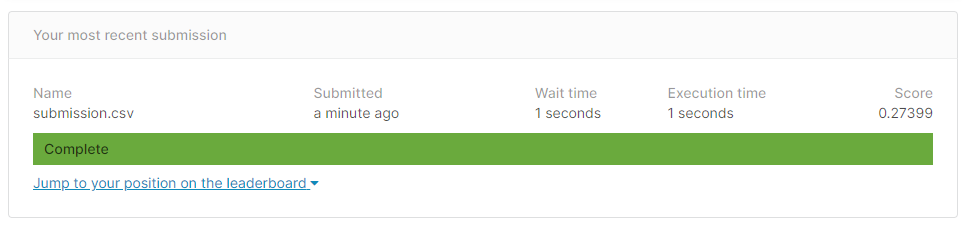

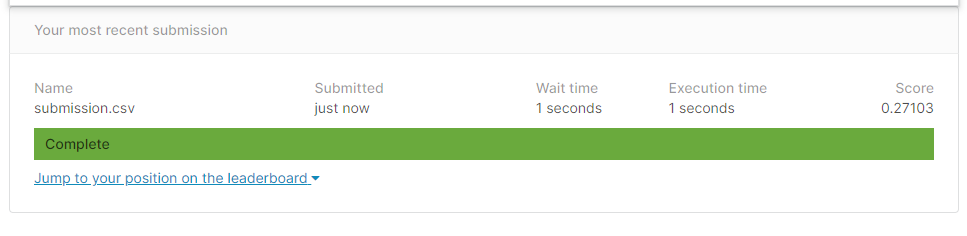

Учитывая, что список id, выдаваемый обоими алгоритмами мало различается, остается только сделать выбор в пользу наивного алгоритма!